In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler
from math import ceil
from itertools import cycle
from itertools import product
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle

In [2]:
#Read in .csv files into pandas dataframes
train       = pd.read_csv('sales_train.csv')
test        = pd.read_csv('test.csv').set_index('ID')
submission  = pd.read_csv('sample_submission.csv')
items       = pd.read_csv('items.csv')
item_cats   = pd.read_csv('item_categories.csv')
shops       = pd.read_csv('shops.csv')

In [3]:
#Down casts the data entries from int64 to int32 and float64 to float32
#This reduces the size of the records by almost half. (From 134mb to 61mb)
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [4]:
#Calls the downcasting function
train      = downcast_dtypes(train)
test       = downcast_dtypes(test)
submission = downcast_dtypes(submission)
items      = downcast_dtypes(items)
item_cats  = downcast_dtypes(item_cats)
shops      = downcast_dtypes(shops)


In [5]:
train = train.merge(items, on='item_id')

In [6]:
train = train.drop(columns = 'item_name')

In [7]:
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')

In [8]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,2013-01-02,0,59,22154,999.0,1.0,37
1,2013-01-23,0,24,22154,999.0,1.0,37
2,2013-01-20,0,27,22154,999.0,1.0,37
3,2013-01-02,0,25,22154,999.0,1.0,37
4,2013-01-03,0,25,22154,999.0,1.0,37
...,...,...,...,...,...,...,...
2935844,2015-10-17,33,25,8428,249.0,1.0,40
2935845,2015-10-01,33,25,7903,12198.0,1.0,15
2935846,2015-10-29,33,25,7610,2890.0,1.0,64
2935847,2015-10-22,33,25,7635,2100.0,1.0,64


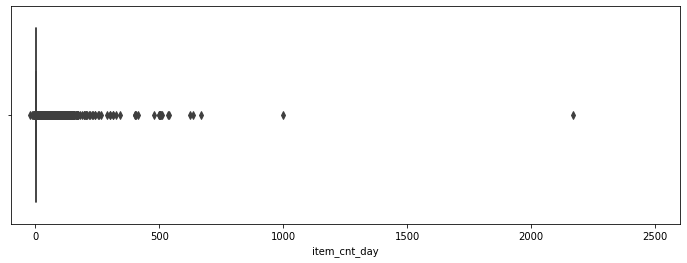

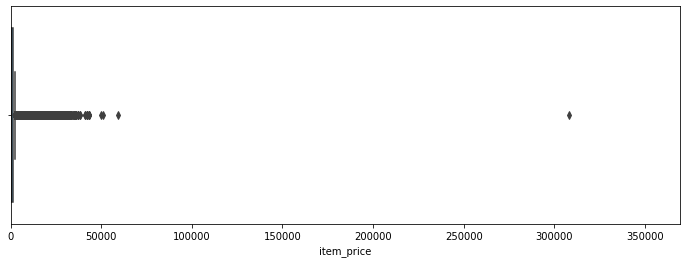

In [9]:
# Boxplot to show outliers in item_cnt_day and item_price
plt.figure(figsize=(12,4))
plt.xlim(-100, train.item_cnt_day.max()*1.2)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(12,4))
plt.xlim(train.item_price.min()*1.1, train.item_price.max()*1.2)
sns.boxplot(x=train.item_price)

In [10]:
#Removes outliers from train
train = train[train.item_price < 90000]
train = train[train.item_cnt_day < 999]

#replaces the negative price item with the median item_price of all items with the id of 2973 and in shop id 32
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()

In [15]:
train.sort_values('item_id')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
2576034,2014-09-01,20,54,0,58.0,1.0,40
2333251,2014-10-20,21,55,1,4490.0,1.0,76
2333246,2014-04-04,15,55,1,4490.0,1.0,76
2333247,2014-04-02,15,55,1,4490.0,1.0,76
2333250,2014-09-11,20,55,1,4490.0,1.0,76
...,...,...,...,...,...,...,...
1139041,2013-02-02,1,42,22168,799.0,1.0,62
1139042,2013-02-17,1,16,22168,799.0,1.0,62
1139043,2013-03-08,2,43,22168,798.5,1.0,62
1139044,2013-09-13,8,12,22168,799.0,1.0,62
